# Main libraries

In [1]:
import os
import sys
sys.path.append('..')
import cv2
import math
import einops
import torch
import torch.fft
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

def show_multiple_images(nrows, ncols, images, titles=None, tight=True, cmaps='gray', figsize=None, dpi=None, masks=None):
    num_imgs = len(images)
    num_plots = int(nrows * ncols)
    cmaps = [cmaps] * num_imgs if not isinstance(cmaps, (tuple, list)) else cmaps
    masks = [masks] * num_imgs if not isinstance(masks, (tuple, list)) else masks
    assert num_imgs <= num_plots, f'num_imgs = {num_imgs}, nrows = {nrows}, ncols = {ncols}.'
    fig, axes = plt.subplots(nrows, ncols, squeeze=False, figsize=figsize, dpi=dpi)
    axes = axes.flatten()
    for i in range(num_imgs):
        img = images[i].cpu().squeeze() if isinstance(images[i], torch.Tensor) else images[i].squeeze()
        mask = masks[i]
        if mask is not None:
            min_val = img.min()
            img[mask == 0] = min_val
        axes[i].imshow(img, cmap=cmaps[i])
        axes[i].axis('off')
        if titles is not None:
            axes[i].set_title(titles[i])
    
    if num_imgs < num_plots:
        for i in range(num_imgs, num_plots):
            axes[i].axis('off')
    if tight:
        fig.tight_layout()


def maybe_mkdir(dir_name):
    os.makedirs(dir_name, exist_ok=True)


def print_array_info(arr, output=False):
    shapes = []
    data_ranges = []
    if not isinstance(arr, (list, tuple)):
        arr = [arr]

    num_arrs = len(arr)
    for i in range(num_arrs):
        shape = tuple(arr[i].shape)
        data_range = (arr[i].min(), arr[i].max())
        if not output:
            print(f'Shape: {shape}, Range: {data_range}.')
        shapes.append(shape)
        data_ranges.append(data_range)

    if output:
        return shapes, data_ranges

# Data processing functions

In [3]:
from utilities.shaping import rescale_array
from wrappers.basic_wrapper import BasicWrapper
from datasets.lowlevel_ct_dataset import DEEPL_DIR, AAPM_DIR

MIN_HU, MAX_HU = -1024, 3072
IMG_SIZE = (256, 256)
PHANTOM = np.load('datasets/phantom.npy')

def resize_image(img):
    return cv2.resize(img, IMG_SIZE, cv2.INTER_CUBIC).astype(img.dtype)

def clip_range(img, min_val=-1024, max_val=3072):
    assert min_val < max_val
    return img.clip(min_val, max_val)

def normalize_hu(hu):
    return (hu - MIN_HU) / (MAX_HU - MIN_HU)

def prepare_ct_image(hu):
    if hu.shape != IMG_SIZE:
        hu = resize_image(hu)
    
    hu = clip_range(hu, MIN_HU, MAX_HU)
    mu = normalize_hu(torch.from_numpy(hu).float())
    return mu.unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]

def prepare_phantom(phantom, remove_bone=True):
    if remove_bone:
        phantom[phantom == 1.] = 0.
    
    hu_range = (MIN_HU, MAX_HU)
    phantom = rescale_array(phantom, hu_range, old_range=(0, 1))
    return prepare_ct_image(phantom)

def read_deepl_image(img_path, as_tensor=True):
    img = np.array(Image.open(img_path))
    img = (img - 32768).astype(np.int16)
    return prepare_ct_image(img) if as_tensor else img

X_PHANTOM = prepare_phantom(PHANTOM)
PWD = os.getcwd()
aapm_test_info = os.path.join(PWD, "datasets/aapm_test.txt")
deepl_train_info = os.path.join(PWD, "datasets/dl_train.txt")
deepl_test_info = os.path.join(PWD, "datasets/dl_test.txt")
aapm_data_dir = AAPM_DIR
deepl_data_dir = DEEPL_DIR

with open(aapm_test_info, "r") as f:
    AAPM_TEST_PATHS = [os.path.join(aapm_data_dir, _.strip()) for _ in f.readlines()]

if os.path.exists(deepl_train_info):
    with open(deepl_train_info, "r") as f:
        DEEPL_TRAIN_PATHS = [os.path.join(deepl_data_dir, _.strip()) for _ in f.readlines()]
else:
    DEEPL_TRAIN_PATHS = []

with open(deepl_test_info, "r") as f:
    DEEPL_TEST_PATHS = [os.path.join(deepl_data_dir, _.strip()) for _ in f.readlines()]

# Incomplete-view CT data preparation

In [5]:
def get_sino_mask(net:BasicWrapper, task_param, task='sparse_view'):
    if task == 'sparse_view':
        sino_mask = net.get_sparse_view_indices_from_full_angles(task_param, return_mask=True)
    elif task == 'limited_angle':
        sino_mask = net.get_limited_angle_indices_from_full_angles(task_param, return_mask=True)
    return sino_mask

def mask2prompt(sino_mask):
    return 1. - sino_mask[:, :, :, 0]

def prepare_sources_contexts(net:BasicWrapper, x, task, task_param, use_phantom=True):
    if use_phantom or len(DEEPL_TRAIN_PATHS) == 0:
        src_w_con = torch.cat((x, X_PHANTOM), dim=0)
    else:
        rand_cont_path = random.choice(DEEPL_TRAIN_PATHS)
        con = read_deepl_image(rand_cont_path, as_tensor=True)
        src_w_con = torch.cat((x, con), dim=0)
        
    input_imgs, target_imgs = net.generate_input_target_mu(src_w_con.cuda(), task_param, task=task)

    lq_imgs, gt_imgs = input_imgs[:1], target_imgs[:1]  # [B, 1, H, W]
    lq_imgs_supp, gt_imgs_supp = input_imgs[-1:], target_imgs[-1:]

    lq_imgs_supp = einops.rearrange(lq_imgs_supp, "(b s) c h w -> b s c h w", b=1)
    gt_imgs_supp = einops.rearrange(gt_imgs_supp, "(b s) c h w -> b s c h w", b=1)
    supp_imgs = torch.cat([lq_imgs_supp, gt_imgs_supp], dim=-3) # [B, S, 2*C, H, W]

    sino_mask = get_sino_mask(net, task_param=task_param, task=task)
    sino_mask = sino_mask.float().repeat_interleave(1, dim=0).to(lq_imgs.device)
    prompt = mask2prompt(sino_mask)
    
    return lq_imgs, gt_imgs, supp_imgs, prompt

@torch.no_grad()
def evaluate_one_image(net, lq_imgs, supp_imgs, prompt):
    pred_imgs = net(lq_imgs, context=supp_imgs, cond=prompt).detach().clamp(0, 1)
    return pred_imgs

# Model definition

In [6]:
from sources.proct import ProCT

net_dict = dict(use_rope=False,block_kwargs={'norm_type':'INSTANCE'},drop_path_rates=0.1,use_spectrals=[True,True,True,False,False],use_learnable_prompt=False,num_heads=[2,4,6,1,1],attn_ratio=[0,1/2,1,0,0])
wrapper_kwargs = dict(img_size=256, simul_poisson_rate=1e6, simul_gaussian_rate=0.01)
net: BasicWrapper = ProCT(1, 1, **net_dict, **wrapper_kwargs)

ckpt_path = "ckpts/proct_v15.pkl"
net.load_state_dict(torch.load(ckpt_path, map_location='cpu')['network'])
net = net.cuda().eval()

full views: 720


# Demo

999
Shape: (1, 1, 256, 256), Range: (tensor(0., device='cuda:0'), tensor(0.5248, device='cuda:0')).
Shape: (1, 1, 256, 256), Range: (tensor(-0.0074, device='cuda:0'), tensor(0.5136, device='cuda:0')).


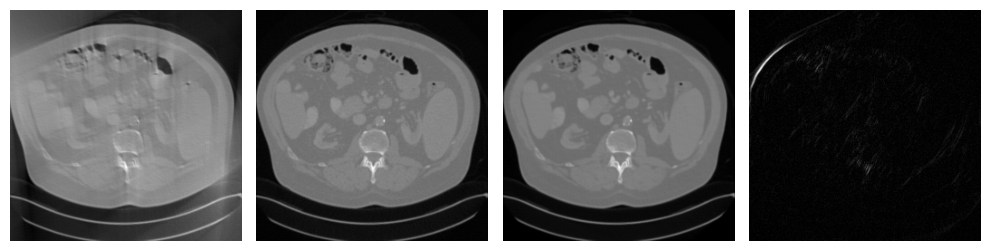

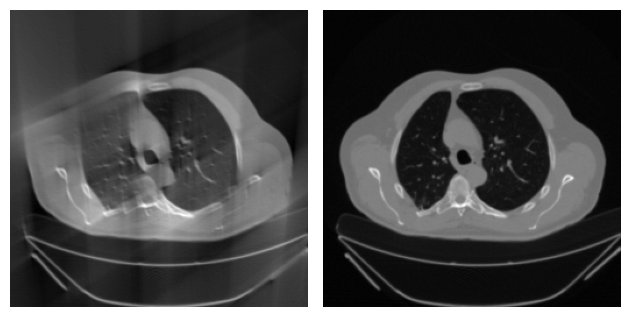

In [10]:
rand_idx = random.choice(range(len(AAPM_TEST_PATHS)))
print(rand_idx)
img_path = AAPM_TEST_PATHS[rand_idx]
img = np.load(img_path)
x = prepare_ct_image(img)
task = 'limited_angle'
task_param = (0, 120)

lq_imgs, gt_imgs, supp_imgs, prompt = prepare_sources_contexts(net, x, task, task_param)
pred_imgs = evaluate_one_image(net, lq_imgs, supp_imgs, prompt)

err_imgs = torch.abs(pred_imgs - gt_imgs)
print_array_info([pred_imgs, gt_imgs])
show_multiple_images(1, 4, [lq_imgs, gt_imgs, pred_imgs, err_imgs], figsize=(10, 4))
show_multiple_images(1, 2, [supp_imgs[:,:,0], supp_imgs[:,:,1]])  # Shows contextual images used